## Relax Data Challenge
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

The data has the following two tables:

1) A user table ("takehome_users") 

2) A usage summary table ("takehome_user_engagement")


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [19]:
users = pd.read_csv('Data/takehome_users.csv', encoding = "ISO-8859-1")

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [21]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [22]:
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s', errors='coerce')

In [25]:
usage = pd.read_csv('Data/takehome_user_engagement.csv')

In [26]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [27]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [28]:
usage.time_stamp = pd.to_datetime(usage.time_stamp)

In [31]:
usage.visited.unique()

array([1])

In [33]:
usage.user_id.nunique()

8823

Visited column contains only one unique value. The number of unique users from this df is equal to the number of users (last_session_creation_time indicating uniques people who have logged on and used the site).

### Adopted Users

Define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period.

In [34]:
usage = usage.sort_values(by=['user_id', 'time_stamp'])

In [35]:
def time_difference(group):
    group['time_for_three'] = group['time_stamp'].diff(periods=2)
    group['days_from_last_login'] = group['time_stamp'].diff(periods=1)//pd.Timedelta(days=1)
    return group

usage = usage.groupby('user_id').apply(time_difference)



In [37]:
usage.head(20)

,time_stamp,user_id,visited,time_for_three,days_from_last_login
0,2014-04-22 03:53:30,1,1,NaT,NaN
1,2013-11-15 03:45:04,2,1,NaT,NaN
2,2013-11-29 03:45:04,2,1,NaT,14.0
3,2013-12-09 03:45:04,2,1,24 days,10.0
4,2013-12-25 03:45:04,2,1,26 days,16.0
5,2013-12-31 03:45:04,2,1,22 days,6.0
6,2014-01-08 03:45:04,2,1,14 days,8.0
7,2014-02-03 03:45:04,2,1,34 days,26.0
8,2014-02-08 03:45:04,2,1,31 days,5.0
9,2014-02-09 03:45:04,2,1,6 days,1.0


In [41]:
# identify grouping of 7 days or less for each user: adopted users
min_delta_by_user = usage.groupby('user_id')['time_for_three'].min()
min_delta_by_user[min_delta_by_user < timedelta(days=7)]

user_id
2       5 days
10      2 days
20      2 days
33      6 days
42      2 days
         ...  
11965   3 days
11967   2 days
11969   2 days
11975   2 days
11988   2 days
Name: time_for_three, Length: 1602, dtype: timedelta64[ns]

In [42]:
# identify grouping of more than 7 days: NOT adopted users
min_delta_by_user[min_delta_by_user >= timedelta(days=7)]

user_id
59      83 days
60       7 days
77      28 days
95      16 days
126     19 days
          ...  
11948   31 days
11949    9 days
11980    9 days
11981   12 days
11991    8 days
Name: time_for_three, Length: 646, dtype: timedelta64[ns]

In [43]:
# identify users that didn't log in at last 3 times
min_delta_by_user[min_delta_by_user.isnull()]

user_id
1       NaT
3       NaT
4       NaT
5       NaT
6       NaT
         ..
11996   NaT
11997   NaT
11998   NaT
11999   NaT
12000   NaT
Name: time_for_three, Length: 6575, dtype: timedelta64[ns]

Of users that logged in at least once, 6575 never logged in again. (It may be good to examine creation_source for these to see if many of these are guests.) Of those with multiple logins, 1602 were adopted users and 646 were not, a ratio of almost 2.5 to 1.


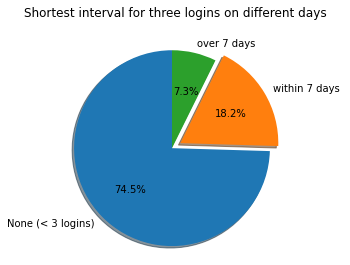

In [47]:
# Pie chart of adopted users vs not:
labels = 'None (< 3 logins)', 'within 7 days', 'over 7 days'
sizes = [min_delta_by_user.isnull().sum(), 
         (min_delta_by_user < timedelta(days=7)).sum(), 
         (min_delta_by_user >= timedelta(days=7)).sum()]
         
explode = (0, 0.1, 0)  # highlight 'adopted users'

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Shortest interval for three logins on different days', pad=24)

plt.show()


In [49]:
# Merge datasets for further analysis
merged = pd.merge(users, usage, how='left', left_on='object_id', right_on='user_id', validate= '1:m')
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   object_id                   211094 non-null  int64          
 1   creation_time               211094 non-null  datetime64[ns] 
 2   name                        211094 non-null  object         
 3   email                       211094 non-null  object         
 4   creation_source             211094 non-null  object         
 5   last_session_creation_time  207917 non-null  datetime64[ns] 
 6   opted_in_to_mailing_list    211094 non-null  int64          
 7   enabled_for_marketing_drip  211094 non-null  int64          
 8   org_id                      211094 non-null  int64          
 9   invited_by_user_id          118528 non-null  float64        
 10  time_stamp                  207917 non-null  datetime64[ns] 
 11  user_id                   

In [50]:
merged.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited,time_for_three,days_from_last_login
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,2014-04-22 03:53:30,1.0,1.0,NaT,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-15 03:45:04,2.0,1.0,NaT,NaN
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-29 03:45:04,2.0,1.0,NaT,14.0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-09 03:45:04,2.0,1.0,24 days,10.0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-25 03:45:04,2.0,1.0,26 days,16.0


In [51]:
# check last_session_creation_time and time_stamp should match for each user
last_time_check = merged[['object_id', 'last_session_creation_time', 'time_stamp']].groupby('object_id').max()
last_time_check


,last_session_creation_time,time_stamp
object_id,,
1,2014-04-22 03:53:30,2014-04-22 03:53:30
2,2014-03-31 03:45:04,2014-03-31 03:45:04
3,2013-03-19 23:14:52,2013-03-19 23:14:52
4,2013-05-22 08:09:28,2013-05-22 08:09:28
5,2013-01-22 10:14:20,2013-01-22 10:14:20
...,...,...
11996,2013-09-06 06:14:15,2013-09-06 06:14:15
11997,2013-01-15 18:28:37,2013-01-15 18:28:37
11998,2014-04-27 12:45:16,2014-04-27 12:45:16


In [52]:
last_time_check[last_time_check.last_session_creation_time.notnull() & 
           (last_time_check.last_session_creation_time != last_time_check.time_stamp)]


,last_session_creation_time,time_stamp
object_id,,


Create columns for adopted_user and features for analysis and modeling.

In [53]:
def adopt_user(group):
    group['adopted_user'] = np.where(group['time_for_three'].min() < timedelta(days=7), 1, 0)
    group['login_count'] = group['time_stamp'].count()
    group['first_login_delta_hours'] = (group['time_stamp'].min() - group['creation_time'].min()) // pd.Timedelta(hours=1)
    group['last_login_delta_hours'] = (group['time_stamp'].max() - group['creation_time'].min()) // pd.Timedelta(hours=1)
    return group

merged = merged.groupby('object_id').apply(adopt_user)

In [55]:
merged.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited,time_for_three,days_from_last_login,adopted_user,login_count,first_login_delta_hours,last_login_delta_hours
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,2014-04-22 03:53:30,1.0,1.0,NaT,NaN,0,1,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-15 03:45:04,2.0,1.0,NaT,NaN,1,14,0.0,3264.0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-29 03:45:04,2.0,1.0,NaT,14.0,1,14,0.0,3264.0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-09 03:45:04,2.0,1.0,24 days,10.0,1,14,0.0,3264.0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-25 03:45:04,2.0,1.0,26 days,16.0,1,14,0.0,3264.0


In [60]:
merged[['object_id', 'user_id', 'login_count', 'time_for_three', 'adopted_user',
       'first_login_delta_hours', 'last_login_delta_hours']].groupby('object_id').min()

,user_id,login_count,time_for_three,adopted_user,first_login_delta_hours,last_login_delta_hours
object_id,,,,,,
1,1.0,1,NaT,0,0.0,0.0
2,2.0,14,5 days,1,0.0,3264.0
3,3.0,1,NaT,0,0.0,0.0
4,4.0,1,NaT,0,24.0,24.0
5,5.0,1,NaT,0,120.0,120.0
...,...,...,...,...,...,...
11996,11996.0,1,NaT,0,0.0,0.0
11997,11997.0,1,NaT,0,120.0,120.0
11998,11998.0,1,NaT,0,0.0,0.0


In [61]:
## columns that we will be using
feat_cols = ['object_id', 'creation_time', 'creation_source', 'last_session_creation_time', 
             'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted_user', 
             'login_count', 'first_login_delta_hours', 'last_login_delta_hours']
features = merged[feat_cols]
features = features.groupby('object_id').max()
features.shape

(12000, 11)

In [63]:
## adopted user is what we want to predict
features['adopted_user'] = features['adopted_user'].astype('category')

In [64]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          6417 non-null   float64       
 7   adopted_user                12000 non-null  category      
 8   login_count                 12000 non-null  int64         
 9   first_login_delta_hours     8823 non-null   float64       
 10  last_login_delta_hours      8823 non-null   float64       
dtypes: category(1), datetime64[ns](2), float64(3), int64(4

In [ ]:
# features[features.adopted_user == 0].describe() # all non-adopted
# features[(features.login_count >= 3) & (features.adopted_user == 0)].describe() # non-adopted who logged in 3+ times
# features[features.adopted_user == 1].describe() # adopted users

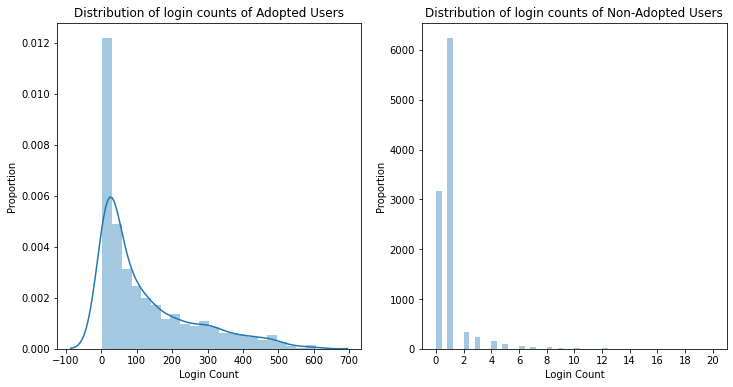

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.distplot(features[features.adopted_user == 1].login_count, ax=ax1)
ax1.set_title('Distribution of login counts of Adopted Users')
ax1.set_ylabel('Proportion')
ax1.set_xlabel('Login Count')

sns.distplot(features[features.adopted_user == 0].login_count, ax=ax2, kde=False)
ax2.set_title('Distribution of login counts of Non-Adopted Users')
ax2.set_ylabel('Proportion')
ax2.set_xticks(np.arange(0, 22, 2))
ax2.set_xlabel('Login Count')
plt.show()

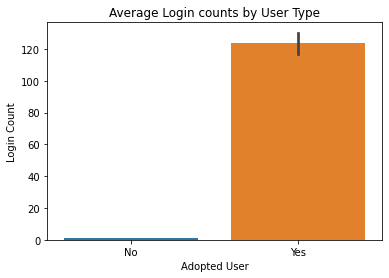

In [68]:
sns.barplot(x='adopted_user', y='login_count', data=features, orient='v')
plt.title('Average Login counts by User Type')
plt.xticks([0, 1], labels=['No', 'Yes'])
plt.xlabel('Adopted User')
plt.ylabel('Login Count')
plt.show()

As one would expect, adopted users logged in more frequently than non-adopted users. The average login count for adopted users is about 120 logins over this time period vs less than 5 logins for non-adopted users.

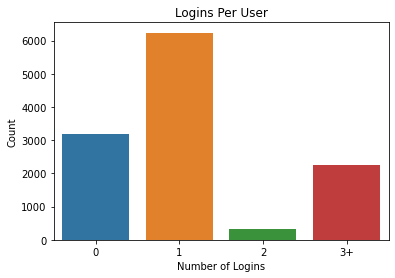

In [69]:
login_bins = pd.Series(dtype='float64')
login_bins['0'] = (features.login_count == 0).sum()
login_bins['1'] = (features.login_count == 1).sum()
login_bins['2'] = (features.login_count == 2).sum()
login_bins['3+'] = (features.login_count >= 3).sum()
sns.barplot(login_bins.index.values, login_bins.values)
plt.title('Total Logins Per User')
plt.xlabel('Number of Logins')
plt.ylabel('Count')
plt.show()

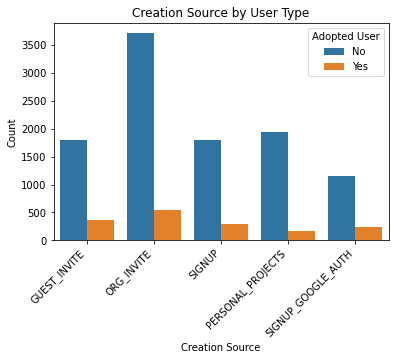

In [72]:
# Where are users coming from?
sns.countplot(x='creation_source', hue='adopted_user', data=features)
plt.title('Creation Source by User Type')
plt.ylabel('Count')
plt.xlabel('Creation Source')
plt.xticks(rotation=45, ha='right')
plt.legend(('No', 'Yes'), title='Adopted User')
plt.show()

Majority of users are invited from an organization.

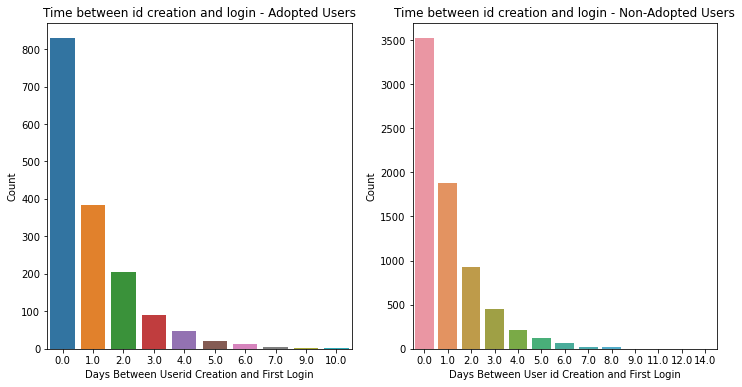

In [74]:
# Time between id creation and first login

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.countplot(features[features.adopted_user == 1].first_login_delta_hours/24, ax=ax1)
ax1.set_title('Time between id creation and login - Adopted Users')
ax1.set_ylabel('Count')
ax1.set_xlabel('Days Between User ID Creation and First Login')

sns.countplot(features[features.adopted_user == 0].first_login_delta_hours/24, ax=ax2)
ax2.set_title('Time between id creation and login - Non-Adopted Users')
ax2.set_ylabel('Count')
ax2.set_xlabel('Days Between User ID Creation and First Login')
plt.show()

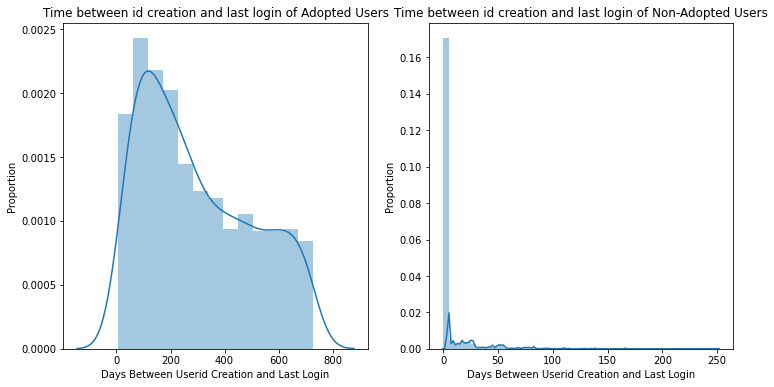

In [76]:
# Time between id creation and first login - proportional

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.distplot(features[features.adopted_user == 1].last_login_delta_hours/24, ax=ax1)
ax1.set_title('Time between id creation and last login of Adopted Users')
ax1.set_ylabel('Proportion')
ax1.set_xlabel('Days Between Userid Creation and Last Login')

sns.distplot(features[features.adopted_user == 0].last_login_delta_hours/24, ax=ax2)
ax2.set_title('Time between id creation and last login of Non-Adopted Users')
ax2.set_ylabel('Proportion')
ax2.set_xlabel('Days Between Userid Creation and Last Login')
plt.show()


In [ ]:
############################

#################
Data preprocessing for modeling.

    Engineer features from email address, dates.
    Change dates to epoch times.
    Change missing invited_by_user_id to 0.
    Change missing last_session_creation_time, last_login_delta_hours to 0.
    Change missing first_login_delta_hours to -1.
    Convert categoricals to dummies.
    Scale numerics.

###########

### Data preprocessing for modeling

In [78]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          6417 non-null   float64       
 7   adopted_user                12000 non-null  category      
 8   login_count                 12000 non-null  int64         
 9   first_login_delta_hours     8823 non-null   float64       
 10  last_login_delta_hours      8823 non-null   float64       
dtypes: category(1), datetime64[ns](2), float64(3), int64(4

In [79]:
features.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [80]:
features['creation_time_epoch'] = (features['creation_time'] - datetime(1970,1,1)) // pd.Timedelta('1s')
features['last_session_creation_time_epoch'] = (features['last_session_creation_time'] - datetime(1970,1,1)) // pd.Timedelta('1s')

In [81]:
features.loc[features['last_session_creation_time_epoch'].isnull(), 'last_session_creation_time_epoch'] = 0
features.loc[features['first_login_delta_hours'].isnull(), 'first_login_delta_hours'] = -1
features.loc[features['last_login_delta_hours'].isnull(), 'last_login_delta_hours'] = 0

In [102]:
ml_features = features.drop(columns=['creation_source','creation_time', 'last_session_creation_time', 'invited_by_user_id'])
ml_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   opted_in_to_mailing_list          12000 non-null  int64   
 1   enabled_for_marketing_drip        12000 non-null  int64   
 2   org_id                            12000 non-null  int64   
 3   adopted_user                      12000 non-null  category
 4   login_count                       12000 non-null  int64   
 5   first_login_delta_hours           12000 non-null  float64 
 6   last_login_delta_hours            12000 non-null  float64 
 7   creation_time_epoch               12000 non-null  int64   
 8   last_session_creation_time_epoch  12000 non-null  float64 
dtypes: category(1), float64(3), int64(5)
memory usage: 1.1 MB


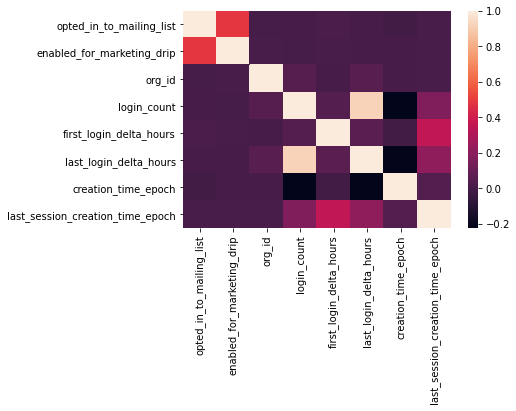

In [103]:
corr = ml_features.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()


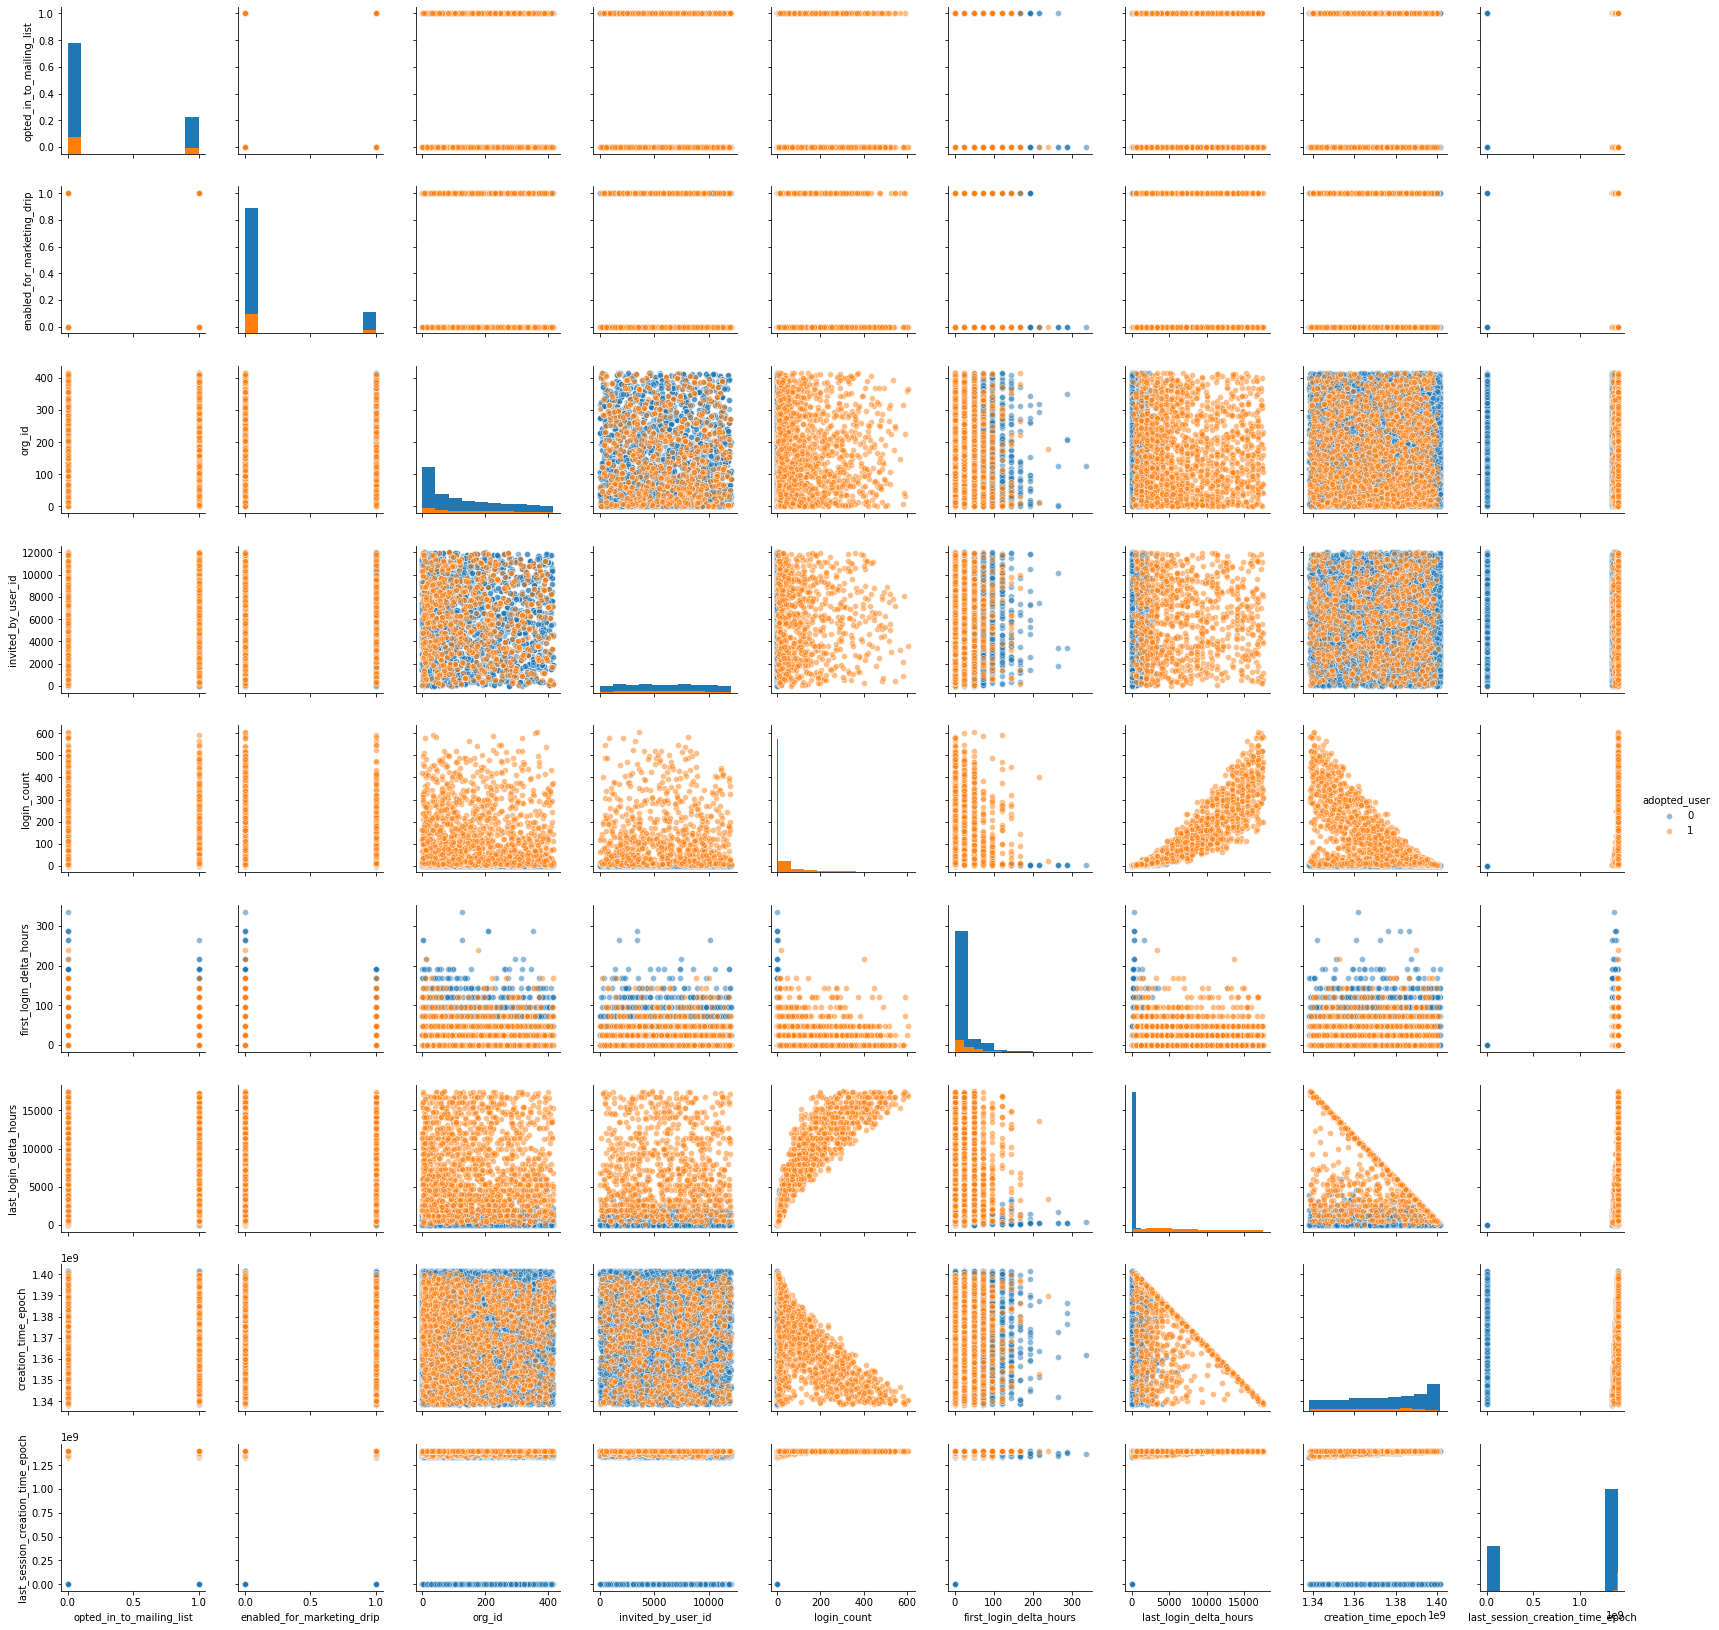

In [104]:
sns.pairplot(features, hue='adopted_user', diag_kind='hist', plot_kws={'alpha':0.5})
plt.show()

#### Train test split

In [105]:
labels = ml_features['adopted_user']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(ml_features, labels, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8400, 9), (8400,), (3600, 9), (3600,))

In [107]:
cont_cols = ['login_count', 'first_login_delta_hours', 'last_login_delta_hours', 'creation_time_epoch', 
             'last_session_creation_time_epoch']
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[cont_cols]))
scaled_X_test = pd.DataFrame(scaler.transform(X_test[cont_cols]))
scaled_X_train.columns = cont_cols
scaled_X_train.index = X_train.index
scaled_X_test.columns = cont_cols
scaled_X_test.index = X_test.index

#### Logistic regression

In [110]:
# Drop last_login_delta_hours, login_count for consecutive runs and see how model feature importance changes. They are 
#   correlated, so will affect feature importance. 
X_train_processed_lr = X_train.drop(columns=['last_login_delta_hours'])
X_test_processed_lr = X_test.drop(columns=['last_login_delta_hours'])

class_names = ['Not Adopted', 'Adopted']
logreg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)
logreg.fit(X_train_processed_lr, y_train)
y_pred = logreg.predict(X_test_processed_lr)
print(classification_report(y_test, y_pred, target_names = class_names))



              precision    recall  f1-score   support

 Not Adopted       0.99      0.97      0.98      3092
     Adopted       0.85      0.95      0.89       508

    accuracy                           0.97      3600
   macro avg       0.92      0.96      0.94      3600
weighted avg       0.97      0.97      0.97      3600



#### Gradient Boosting

In [114]:
class_names = ['Not Adopted', 'Adopted']
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

 Not Adopted       1.00      1.00      1.00      3092
     Adopted       1.00      1.00      1.00       508

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600

